In [ ]:
from pandas_datareader import data
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns

In [ ]:
start_date = dt.datetime.now() - dt.timedelta(days=365 * 50)
end_date = dt.datetime.now()

df = yf.download("AMAT", start=start_date, end=end_date)

df.reset_index(inplace=True)

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['50_day_ma'] = df['Close'].rolling(window=50).mean()
df['1000_day_ma'] = df['Close'].rolling(window=1000).mean()
df['10_day_vol_avg'] = df['Volume'].rolling(window=10).mean()
df['200_day_vol_avg'] = df['Volume'].rolling(window=200).mean()

#TODO: make function to shift closing price 50 days in the future

df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']]

df.to_csv('AMAToutput.csv', index=False)

print(df)

[*********************100%***********************]  1 of 1 completed
            Date        Open        High         Low       Close   Volume  \
0     1980-03-17    0.000000    0.098090    0.095486    0.095486  3600000   
1     1980-03-18    0.000000    0.096354    0.093750    0.093750  3715200   
2     1980-03-19    0.000000    0.098090    0.095486    0.095486  2016000   
3     1980-03-20    0.000000    0.099826    0.097222    0.097222  3657600   
4     1980-03-21    0.000000    0.103299    0.100694    0.100694  3024000   
...          ...         ...         ...         ...         ...      ...   
10931 2023-07-26  137.630005  140.289993  136.809998  139.020004  4050400   
10932 2023-07-27  144.229996  150.429993  144.210007  146.139999  8928900   
10933 2023-07-28  149.580002  153.279999  148.699997  151.929993  7802000   
10934 2023-07-31  151.929993  152.679993  150.520004  151.589996  4184400   
10935 2023-08-01  150.919998  152.860001  150.279999  152.630005  3088100   

      

In [ ]:
#dfm = df.loc[1000:,:]
#dfm = dfm.sample(100)

In [ ]:
#corr = dfm.corr()
#corr.style.background_gradient(cmap='coolwarm').format(precision=2)

In [ ]:
#sns.lmplot(data=dfm, x='50_day_ma', y='1000_day_ma')

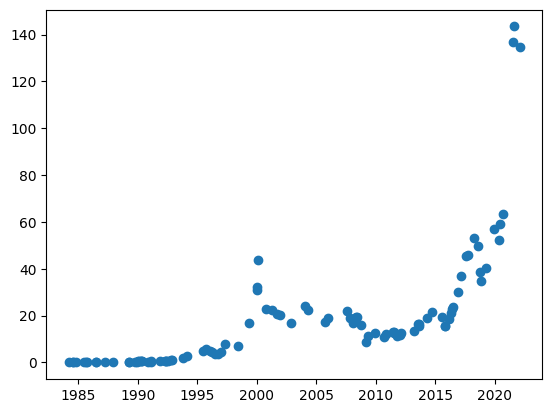

In [ ]:
plt.plot_date(dfm['Date'], dfm['Open'])

In [ ]:
#df.set_index('Date', inplace=True)

df.dropna(inplace=True)

df = df.drop(df.index[0:2000])

train_df = df.sort_values(by=['Date']).copy()

#FEATURES = ['Close', '50_day_ma', '200_day_ma']
FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']

print('FEATURE LIST')
print([f for f in FEATURES])

print(df)

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']
            Date        Open        High         Low       Close    Volume  \
2999  1992-01-27    0.593750    0.597656    0.582031    0.589844   6912000   
3000  1992-01-28    0.597656    0.605469    0.593750    0.597656  10969600   
3001  1992-01-29    0.593750    0.628906    0.593750    0.609375  17113600   
3002  1992-01-30    0.609375    0.625000    0.582031    0.597656  16531200   
3003  1992-01-31    0.597656    0.607422    0.593750    0.599609   4000000   
...          ...         ...         ...         ...         ...       ...   
10931 2023-07-26  137.630005  140.289993  136.809998  139.020004   4050400   
10932 2023-07-27  144.229996  150.429993  144.210007  146.139999   8928900   
10933 2023-07-28  149.580002  153.279999  148.699997  151.929993   7802000   
10934 2023-07-31  151.929993  152.679993  150.520004  151.589996   4184400   
10935 2023-08-01  150

<ipython-input-95-76947fff0d9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
sequence_length = 200

index_Close = data_filtered.columns.get_loc("Close")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

In [ ]:
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    print(index_Close)
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close])

    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

3
3
(6944, 200, 9) (6944,)
(793, 200, 9) (793,)
0.0030037077102985765
0.0030037077102985765
1800 200 9


In [ ]:
model.compile(optimizer='adam', loss='mse')

epochs = 16
batch_size = 32
early_stop = EarlyStopping(monitor='loss', patience = 3, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/16
132/217 [=================>............] - ETA: 48s - loss: 0.0194

KeyboardInterrupt: ignored

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

In [ ]:
display_start_date = "2023-01-01"

train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("AMAT", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

X_test_new = []
X_test_new.append(last_N_days_scaled)

pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''

print(f'The close price for {"AMAT"} at {str(dt.date.today())} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')


In [ ]:
#test_loss, test_acc = model.evaluate(test_images, test_labels, verbose = 2)
#print(test_acc)

df_temp = df[-sequence_length-250:-50]
new_df = df_temp.filter(FEATURES)

N = sequence_length

for i in range(50):
  last_N_days = new_df[-sequence_length:].values
  last_N_days_scaled = scaler.transform(last_N_days)

  print(last_N_days)

  X_test_new = []
  X_test_new.append(last_N_days_scaled)

  pred_price_scaled = model.predict(np.array(X_test_new))
  pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

  price_today = np.round(new_df['Close'][-1], 2)
  predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
  change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

  if (i < 3):
    new_df.loc[dt.date.today()+timedelta(days=i-50)] = [predicted_price,0,0]
  else:
    new_df.loc[dt.date.today()+timedelta(days=i-50)] = [predicted_price,0,0]

  new_df['50_day_ma'] = new_df['Close'].rolling(window=50).mean()
  new_df['200_day_ma'] = new_df['Close'].rolling(window=180).mean()


  print(new_df)

new_df.reset_index(inplace=True)

plt.figure(figsize = (18,9))
plt.plot(range(df[-100:].shape[0]),df['Close'][-100:])
plt.plot(range(new_df[-100:].shape[0]),new_df['Close'][-100:])
plt.xticks(range(0,new_df.shape[0],500),new_df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.title('Closing Price of AMAT',fontsize=22)
plt.show()


In [ ]:
#Graph the closing price of AMAT

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df['Close'])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.title('Closing Price of AMAT',fontsize=22)
plt.show()